In [165]:
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator , TransformerMixin
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [153]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Article Titles

In [154]:
PATH = r'C:\Users\PC\Desktop\article_titles.csv'
data = pd.read_csv(PATH)
print('Total number of articles : ' , len(data))

Total number of articles :  366


In [155]:
data.head()

,_id,title
0,66bbcdafc06bd913e4c97d69,"PM Shehbaz hosts Arshad Nadeem for dinner, ann..."
1,66bbcdafc06bd913e4c97d6b,Karachi's Dawood University VC Dr Samreen rema...
2,66bbcdafc06bd913e4c97d6c,Visa fee for 126 countries waived under new po...
3,66bbcdafc06bd913e4c97d6d,Proposed revision in passport rules allows cit...
4,66bbcdafc06bd913e4c97d6e,Pakistan expresses grave concerns over illicit...


# Custom Sklearn Transformer For Vector Embedding

In [156]:
class EmbeddingTransformer(BaseEstimator , TransformerMixin):
    
    def __init__(self , model_name = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        
    def fit(self , X , y=None):
        return self
    
    def transform(self , X):
        return self.model.encode(X)

# Create Pipeline For DBSCAN

In [157]:
embeddingTransformer = EmbeddingTransformer()
pca = PCA(n_components=0.90) 
dbscan = DBSCAN(eps=0.6 , min_samples=2 , n_jobs=-1)
#min_samples = 2 means that a data point must contain at least two other data points within its radius to be considered a core
#eps is the max distance between two points to be considered in same neighborhood

In [158]:
dbscan_pipeline = Pipeline([
    ('embedding' , embeddingTransformer),
    ('pca' , pca),
    ('model' , dbscan)
])

In [159]:
labels_predicted = dbscan_pipeline.fit_predict(data.title.values)

# Calculate Silhouette Score

In [160]:
X = dbscan_pipeline.named_steps['embedding'].transform(data.title.values)
X = dbscan_pipeline.named_steps['pca'].transform(X)
score = silhouette_score(X , labels_predicted)

In [161]:
np.sum(dbscan_pipeline.named_steps['pca'].explained_variance_ratio_)

0.9004379

In [162]:
print(r'Silhouette Score (-1 to 1) :  ' , score)
print('Score closer to 1 means the cluster is dense and well separated')

Silhouette Score (-1 to 1) :   0.4266439
Score closer to 1 means the cluster is dense and well separated


In [198]:
results = zip(data.title.values , labels_predicted)
sorted_data = sorted(results, key=lambda x: x[1])
blindspot_articles = 0
for item in sorted_data:
    if(item[1] == -1):
        blindspot_articles += 1
    print(item)
    
print('\nNumber of Blindspots : ' , blindspot_articles)

('‘Remarkable achievement’: COAS Munir lauds Arshad Nadeem for Olympic win', -1)
('Three killed as rain batters  parts of Balochistan', -1)
("Sukkur breaks '77-year record' with 290mm rain in a day", -1)
('Devastating monsoon rains claim 19 lives in Balochistan', -1)
('Karachi braces for likely rise in temperatures in coming days', -1)
('FIA arrests Orya Maqbool Jan in Lahore for posting about Mubarak Sani case on social media', -1)
("FIA arrests Orya Maqbool Jan, case lodged for 'remarks against institutions'", -1)
('Lahore court approves Orya Maqbool’s 4-day physical remand over posts on Mubarak Sani case', -1)
("PTI not 'disturbed' over Imran Khan's incarceration, insists former KP minister", -1)
("PTI not 'disturbed' over Imran Khan's imprisonment, to hold Islamabad rally on Sept 8", -1)
("'Dil Ka Rishta' earns massive praise at ISNA's annual gathering in Dallas", -1)
('Dil Ka Rishta app attracts large number of people at ISNA', -1)
('Imran petitions IHC against ‘possible’ military

# 13 articles are clustered incorrectly and are being treated as anomolies
# ( 353 / 366 ) * 100 = 96% are clustered correctly

# Create Pipeline For Agglomerative Clustering

In [190]:
agglo_pipeline = Pipeline([
    ('embedding' , embeddingTransformer),
    ('pca' , pca),
    ('model' , AgglomerativeClustering(n_clusters=None , distance_threshold=0.7))
])

In [191]:
labels_agglo = agglo_pipeline.fit_predict(data.title.values)

In [192]:
np.max(labels_agglo)

156

In [193]:
results = zip(data.title.values , labels_agglo)
sorted_data = sorted(results, key=lambda x: x[1])

for item in sorted_data:
    print(item)
    
print(i)

('UK riots: Lahore man arrested for allegedly spreading disinformation', 0)
("Suspect arrested in Lahore for 'triggering UK riots via fake news'", 0)
('UK riots: Lahore court discharges man in disinformation case', 0)
('UK riots: Lahore court clears man in disinformation case', 0)
('Karachi mayor warns against unneccessary movement with more rain expected from potential cyclone', 1)
("Cyclonic storm: Karachiites urged to avoid 'unnecessary movement' amid heavy rain forecast", 1)
("'Unusual' cyclonic storm: Karachiites warned against unnecessary movement", 1)
('Karachi weather update: PMD forecasts more rain in next 24 hours', 2)
('Light showers soak Karachi as PMD forecasts more rain in next 24 hours', 2)
('PMD forecasts heavy rain, urban flooding for Karachi this weekend', 2)
('Rain in Karachi: PMD revises weather advisory for metropolis', 2)
('Karachi weather update: Will it rain in port city?', 2)
('PMD forecasts scattered drizzle, rain in Karachi', 2)
("Karachi weather update: City

In [194]:
score = silhouette_score(X , labels_agglo)
score

0.45224166

In [195]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


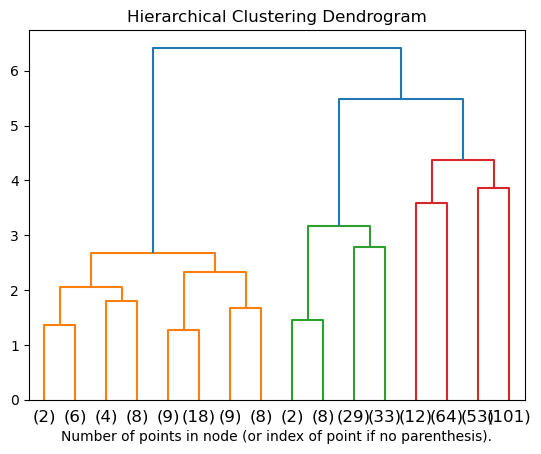

In [196]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_pipeline.named_steps['model'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()